In [1]:
from torch import nn
from typing import *
from torch.nn import init

class Input_Layer(nn.Module):
    def __init__(self, in_channels,out_channels,*args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1=nn.Conv1d(in_channels=in_channels,out_channels=out_channels,kernel_size=7,stride=1,padding=3)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1=nn.ReLU()
        self.maxp1=nn.MaxPool1d(kernel_size=3,stride=2)
    def __call__(self,x, *args: Any, **kwds: Any) -> Any:
        x=self.conv1(x)
        x=self.bn1(x)
        
        x=self.relu1(x)
        
        x=self.maxp1(x)
        return x 

        pass
class Down_Sample_Layer(nn.Module):
    def __init__(self, in_channels,out_channels,*args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv2=nn.Conv1d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,stride=2,padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2=nn.ReLU()
    def __call__(self, x,*args: Any, **kwds: Any) -> Any:
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.relu2(x)
        return x


    
    
class Classfier_Layer(nn.Module):
    def __init__(self, in_features,out_features,hidden_num,*args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.avgpool=nn.AdaptiveAvgPool1d(1)
        self.flatten=nn.Flatten()
        
        self.relu1=nn.ReLU()

        self.linear1=nn.Linear(in_features=in_features,out_features=hidden_num)

        self.relu2=nn.ReLU()

        self.linear2=nn.Linear(in_features=hidden_num,out_features=out_features)
    def __call__(self,x, *args: Any, **kwds: Any) -> Any:
        x=self.avgpool(x)
        x=self.flatten(x)
        #print(x.shape)
        x=self.relu1(x)
        #print(x.shape)
        x=self.linear1(x)
        #print(x.shape)
        x=self.relu2(x)
        x=self.linear2(x)

        return x




from typing import Any


class simple_cnn1d(nn.Module):
    def __init__(self, input_channels,num_classes,list_down:list,num_hidden=32,*args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.list_down=list_down
        #print(self.list_down)
        self.num_classes=num_classes
        #print(num_classes)

        self.input_layer=Input_Layer(in_channels=input_channels,out_channels=list_down[0])
        for i in range(len(self.list_down)-1):
            #print(i)
            setattr(self,f'down_blk{i}',Down_Sample_Layer(self.list_down[i],self.list_down[i+1]))
        self.classfier_layer=Classfier_Layer(self.list_down[-2],self.num_classes,num_hidden)
       
    def __call__(self, x,*args: Any, **kwds: Any) -> Any:
        x=self.input_layer(x)
        #print(self.list_down)
        for i in range(len(self.list_down)-1):
            blk=getattr(self,f"down_blk{i}")
            x=blk(x)
        x=self.classfier_layer(x)
        return x

    

# 原始Residual块

In [2]:
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [3]:
from torchsummary import summary
blk = Residual(3,3)
summary(blk,(3,224,224),batch_size=3,device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [3, 3, 224, 224]              84
       BatchNorm2d-2           [3, 3, 224, 224]               6
            Conv2d-3           [3, 3, 224, 224]              84
       BatchNorm2d-4           [3, 3, 224, 224]               6
Total params: 180
Trainable params: 180
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.72
Forward/backward pass size (MB): 13.78
Params size (MB): 0.00
Estimated Total Size (MB): 15.50
----------------------------------------------------------------


# Residual1D

In [4]:
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
from torchsummary import summary


In [5]:
class Residual1D(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv1d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv1d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
def resnet_block1d(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual1D(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual1D(num_channels, num_channels))
    return blk
featureNum=3
b1OutChannel=64
b2OutChannel=64
b3OutChannel=128
b4OutChannel=256
b5OutChannel=512
classNum=3
b1 = nn.Sequential(nn.Conv1d(featureNum, b1OutChannel, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm1d(64), nn.ReLU(),
                   nn.MaxPool1d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block1d(b1OutChannel,b2OutChannel, 2, first_block=True))
b3 = nn.Sequential(*resnet_block1d(b2OutChannel, b3OutChannel, 2))
b4 = nn.Sequential(*resnet_block1d(b3OutChannel, b4OutChannel, 2))
b5 = nn.Sequential(*resnet_block1d(b4OutChannel, b5OutChannel, 2))
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(b5OutChannel,classNum))
summary(net,(3,7680),batch_size=3,device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [3, 64, 3840]           1,408
       BatchNorm1d-2              [3, 64, 3840]             128
              ReLU-3              [3, 64, 3840]               0
         MaxPool1d-4              [3, 64, 1920]               0
            Conv1d-5              [3, 64, 1920]          12,352
       BatchNorm1d-6              [3, 64, 1920]             128
            Conv1d-7              [3, 64, 1920]          12,352
       BatchNorm1d-8              [3, 64, 1920]             128
        Residual1D-9              [3, 64, 1920]               0
           Conv1d-10              [3, 64, 1920]          12,352
      BatchNorm1d-11              [3, 64, 1920]             128
           Conv1d-12              [3, 64, 1920]          12,352
      BatchNorm1d-13              [3, 64, 1920]             128
       Residual1D-14              [3, 6

# 训练

## 路径

In [6]:
import os
import sys
root=os.path.abspath(os.path.join(r"D:\project_meta\NNproject\NNI\notebook\NNITest_0231104.ipynb","../.."))
print(root)
sys.path.append(root)
os.environ["TORCH_HOME"]=r"E:\Data\torch-model"
import warnings  
warnings.filterwarnings("ignore", category=RuntimeWarning, module="mne")
data_root=r'D:\dataset\driver_dataset\DROZY\DROZY'
output_root=r"D:\project_meta\NNproject\NNI\output"

D:\project_meta\NNproject\NNI


## 数据集

In [7]:
import torch
import pandas as pd
from project.dataprocess import FolderTree
from project.dataset.SelfDataset import TableControlFullLoadDataset
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
data_path_dict=FolderTree.getDataPath(data_root=data_root)
output_path_dic=FolderTree.getOutPath(output_root=output_root)

info_table=pd.read_csv(output_path_dic["info_file"])


#随机分配
train_data_table,test_data_table=train_test_split(info_table,test_size=0.2,shuffle=True)

train_dataset=TableControlFullLoadDataset(train_data_table,data_root=data_root,output_root=output_root,Mintime=15)
train_dataloader=DataLoader(train_dataset,batch_size=64,shuffle=True)

test_dataset=TableControlFullLoadDataset(test_data_table,data_root=data_root,output_root=output_root)
test_dataloader=DataLoader(test_dataset,batch_size=512)

In [8]:
data=next(iter(test_dataloader))

## 训练超参

In [9]:
import torch
from d2l import torch as d2l
import torch.nn.functional as F
import datetime
import sklearn as sk
from sklearn.metrics import precision_score, recall_score, f1_score
device=torch.device("cuda")
optim=torch.optim.SGD(net.parameters(),lr=0.05,weight_decay=5e-4)
loss=torch.nn.CrossEntropyLoss().to(device="cuda")
num_epochs=2000



## 权重存储路径

In [10]:

current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")
parameterFolder=os.path.join(r"D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D",f"{formatted_time}")
print(parameterFolder)
os.makedirs(parameterFolder)


D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D\2023_11_09_10_16_16


In [11]:
class Residual1D(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv1d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv1d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
def resnet_block1d(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual1D(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual1D(num_channels, num_channels))
    return blk
featureNum=5
b1OutChannel=64
b2OutChannel=64
b3OutChannel=128
b4OutChannel=256
b5OutChannel=512
classNum=3
b1 = nn.Sequential(nn.Conv1d(featureNum, b1OutChannel, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm1d(64), nn.ReLU(),
                   nn.MaxPool1d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block1d(b1OutChannel,b2OutChannel, 2, first_block=True))
b3 = nn.Sequential(*resnet_block1d(b2OutChannel, b3OutChannel, 2))
b4 = nn.Sequential(*resnet_block1d(b3OutChannel, b4OutChannel, 2))
b5 = nn.Sequential(*resnet_block1d(b4OutChannel, b5OutChannel, 2))
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(b5OutChannel,classNum))
summary(net,(featureNum,7680),batch_size=3,device='cpu')
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(b5OutChannel,classNum)).to(device)
optim=torch.optim.SGD(net.parameters(),lr=0.05,weight_decay=5e-4)
loss=torch.nn.CrossEntropyLoss().to(device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [3, 64, 3840]           2,304
       BatchNorm1d-2              [3, 64, 3840]             128
              ReLU-3              [3, 64, 3840]               0
         MaxPool1d-4              [3, 64, 1920]               0
            Conv1d-5              [3, 64, 1920]          12,352
       BatchNorm1d-6              [3, 64, 1920]             128
            Conv1d-7              [3, 64, 1920]          12,352
       BatchNorm1d-8              [3, 64, 1920]             128
        Residual1D-9              [3, 64, 1920]               0
           Conv1d-10              [3, 64, 1920]          12,352
      BatchNorm1d-11              [3, 64, 1920]             128
           Conv1d-12              [3, 64, 1920]          12,352
      BatchNorm1d-13              [3, 64, 1920]             128
       Residual1D-14              [3, 6

torch.Size([64])
torch.Size([64, 3])
torch.Size([64])
torch.Size([64, 3])
torch.Size([64])
torch.Size([64, 3])


KeyboardInterrupt: 

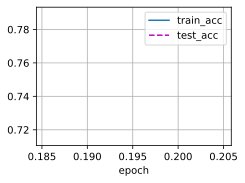

In [15]:
animator = d2l.Animator(xlabel='epoch',
                        legend=['train_acc','test_acc'])   
timer, num_batches = d2l.Timer(), len(train_dataloader)
best_train_acc=0
best_train_loss=0
best_test_acc=0
stagnate_times=0
temp_acc=0
num_epochs=4
for epoch in range(num_epochs):
    metric_train = d2l.Accumulator(2)
    net.train()
    for i,data_dict in enumerate(train_dataloader):
        optim.zero_grad()
        x=data_dict["data"].to(torch.float32).to(device)     
        y=data_dict["LEVEL"].long().to(device)-1
        y_hat=net(x)
        print(y.shape)
        print(y_hat.shape)
        l=F.cross_entropy(y_hat, y)
        l.mean().backward()
        optim.step()     
        pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        num_true=sum(pre==y.cpu())
        metric_train.add(num_true,y.numel())
        if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
            animator.add(epoch + (i + 1) / num_batches, (metric_train[0]/metric_train[1],None))
    
    net.eval()
    metric_test = d2l.Accumulator(2)
    for data_dict in test_dataloader:
        x=data_dict["data"].to(torch.float32).to(device)
        y=data_dict["LEVEL"].long().to(device)
        y_hat=net(x)
       
        pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        num_true=sum(pre==y.cpu())
        metric_test.add(num_true,y.numel())
    animator.add(epoch+ 1, (None,metric_test[0]/metric_test[1]))
    
    stagnate_times=stagnate_times+1
    if best_test_acc<(metric_test[0]/metric_test[1]):
        best_test_acc=metric_test[0]/metric_test[1]
        stagnate_times=0
        torch.save(net.state_dict(),os.path.join(parameterFolder,f'{best_test_acc}.pt'))
    if temp_acc<metric_test[0]/metric_test[1]:
        stagnate_times=0 
    temp_acc= metric_test[0]/metric_test[1]          
    if stagnate_times>20:
        break

## 三角波和sin波分类

In [41]:
from torch.utils.data import *
from typing import Any
import numpy as np
class cnn1d_testdataset(Dataset):
    def __init__(self) -> None:
        super().__init__()
        a=10
        t=np.linspace(0,1,1000)
        self.sin=np.sin(17*np.pi*t)
        self.tri=np.zeros_like(t)
        for i,j in  enumerate(t):
            
            if i%(2*a)<a:
                self.tri[i]=(i%a)/a
            else:
                self.tri[i]=-1*(i%a)/a+1
        
    def __len__(self):
        return 2000
    def __getitem__(self, index) -> Any:
        start_index=np.random.randint(0,9)
        
        if index<1000:
            return self.tri[start_index*100+index%100:start_index*100+index%100+100],0
        else:
            return self.sin[start_index*100+index%100:start_index*100+index%100+100],1
batch_size=4
dataset=cnn1d_testdataset()
dataloader=DataLoader(dataset,batch_size=batch_size,drop_last=True)

In [48]:
class Residual1D(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv1d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv1d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
def resnet_block1d(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual1D(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual1D(num_channels, num_channels))
    return blk
featureNum=5
b1OutChannel=64
b2OutChannel=64
b3OutChannel=128
b4OutChannel=256
b5OutChannel=512
classNum=3
b1 = nn.Sequential(nn.Conv1d(featureNum, b1OutChannel, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm1d(64), nn.ReLU(),
                   nn.MaxPool1d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block1d(b1OutChannel,b2OutChannel, 2, first_block=True))
b3 = nn.Sequential(*resnet_block1d(b2OutChannel, b3OutChannel, 2))
b4 = nn.Sequential(*resnet_block1d(b3OutChannel, b4OutChannel, 2))
b5 = nn.Sequential(*resnet_block1d(b4OutChannel, b5OutChannel, 2))
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(b5OutChannel,classNum))
summary(net,(featureNum,7680),batch_size=3,device='cpu')
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(b5OutChannel,classNum)).to(device)
optim=torch.optim.SGD(net.parameters(),lr=0.05,weight_decay=5e-4)
loss=torch.nn.CrossEntropyLoss().to(device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [3, 64, 3840]           2,304
       BatchNorm1d-2              [3, 64, 3840]             128
              ReLU-3              [3, 64, 3840]               0
         MaxPool1d-4              [3, 64, 1920]               0
            Conv1d-5              [3, 64, 1920]          12,352
       BatchNorm1d-6              [3, 64, 1920]             128
            Conv1d-7              [3, 64, 1920]          12,352
       BatchNorm1d-8              [3, 64, 1920]             128
        Residual1D-9              [3, 64, 1920]               0
           Conv1d-10              [3, 64, 1920]          12,352
      BatchNorm1d-11              [3, 64, 1920]             128
           Conv1d-12              [3, 64, 1920]          12,352
      BatchNorm1d-13              [3, 64, 1920]             128
       Residual1D-14              [3, 6

In [45]:
dataset=cnn1d_testdataset()
batch_size=5
train_dataloader=DataLoader(dataset,batch_size=batch_size,drop_last=True)
next(iter(train_dataloader))[0].shape

torch.Size([5, 100])

tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]])


RuntimeError: Given groups=1, weight of size [64, 5, 7], expected input[5, 1, 100] to have 5 channels, but got 1 channels instead

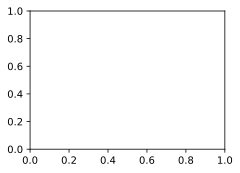

In [50]:
animator = d2l.Animator(xlabel='epoch',
                        legend=['train_acc','test_acc'])   
timer, num_batches = d2l.Timer(), len(train_dataloader)
best_train_acc=0
best_train_loss=0
best_test_acc=0
stagnate_times=0
temp_acc=0
for epoch in range(num_epochs):
    metric_train = d2l.Accumulator(2)
    net.train()
    for x,y in train_dataloader:
        x=x.to(torch.float32).unsqueeze(1).to(device)
        #print(x.shape)
        y=y.to(device)
        y=F.one_hot(y,2)
        print(y)
        #前向计算
        y_hat=net(x)
        loss=loss(y_hat,y)
        #反向传播
        optim.zero_grad()
        loss.backward()

        pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        num_true=sum(pre==y.cpu())
        metric_train.add(num_true,y.numel())
        if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
            animator.add(epoch + (i + 1) / num_batches, (metric_train[0]/metric_train[1],None))
    
    net.eval()
    metric_test = d2l.Accumulator(2)
    # for data_dict in test_dataloader:
    #     x=data_dict["data"].to(torch.float32).to(device)
    #     y=data_dict["LEVEL"].long().to(device)
    #     y_hat=net(x)
    #     pre=torch.argmax(y_hat.detach().cpu(),dim=1)
    #     num_true=sum(pre==y.cpu())
    #     metric_test.add(num_true,y.numel())
    # animator.add(epoch+ 1, (None,metric_test[0]/metric_test[1]))
    
    # stagnate_times=stagnate_times+1
    # if best_test_acc<(metric_test[0]/metric_test[1]):
    #     best_test_acc=metric_test[0]/metric_test[1]
    #     stagnate_times=0
    #     torch.save(net.state_dict(),os.path.join(parameterFolder,f'{best_test_acc}.pt'))
    # if temp_acc<metric_test[0]/metric_test[1]:
    #     stagnate_times=0 
    # temp_acc= metric_test[0]/metric_test[1]          
    # if stagnate_times>20:
    #     break